<a href="https://colab.research.google.com/github/wallik3/movie-len-recommendation/blob/main/notebooks/1_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o moven_len_100k.zip https://raw.githubusercontent.com/wallik3/movie-len-recommendation/main/artifact/dataset/ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1988k      0 --:--:-- --:--:-- --:--:-- 1990k


In [2]:
!unzip moven_len_100k.zip -d moven_len_100k
!mv moven_len_100k/ml-latest-small/* moven_len_100k/
!rm -rf moven_len_100k.zip

Archive:  moven_len_100k.zip
   creating: moven_len_100k/ml-latest-small/
  inflating: moven_len_100k/ml-latest-small/links.csv  
  inflating: moven_len_100k/ml-latest-small/tags.csv  
  inflating: moven_len_100k/ml-latest-small/ratings.csv  
  inflating: moven_len_100k/ml-latest-small/README.txt  
  inflating: moven_len_100k/ml-latest-small/movies.csv  


## About This Notebook
- ⛳ Our goal is to recommend movies to users, a crucial task in the industry for upselling and other purposes. In this case, we focus on the MovieLens platform. To achieve this, we will implement a machine learning framework to develop a recommendation system. We will use the commonly employed technique of matrix factorization and demonstrate the results through a user collaborative learning framework.


In [3]:
import pandas as pd
import datetime
from scipy.sparse import csr_matrix
import numpy as np

from sklearn.metrics import recall_score
from typing import List, Tuple
from tqdm import tqdm
import itertools

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import torch.nn.functional as F

## Import Data
- There are four main tables, though only a few will be utilized.

In [4]:
# Explore data, there is 4 tables
movies = pd.read_csv("/content/moven_len_100k/movies.csv")
ratings = pd.read_csv("/content/moven_len_100k/ratings.csv")
links = pd.read_csv("/content/moven_len_100k/links.csv")
tags = pd.read_csv("/content/moven_len_100k/tags.csv")

In [5]:
# movie_id title and genre(s)
display(movies)
# A pair of user_id and movie_id with rating and rated timestamp (will be convert to datetime)
display(ratings)
# Great when you want to further scrape the information like overall rating and image
display(links)
# Tag made by user, only 3000+ tag made by user
display(tags)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


## Exploratory Data Analysis
- Let's understand our data before we build the recommendation system.


In [6]:
def check_null_counts(df):
    """
    Return null counts for all columns
    """
    return df.isnull().sum()

# No null was found for all df
print(check_null_counts(ratings))
print(check_null_counts(movies))
print(check_null_counts(links))
print(check_null_counts(tags))

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


🔍 Explore superficially

In [7]:
# Convert each timestamp to a human-readable date
ratings["timestamp"] = ratings.timestamp.map(lambda ts : datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [8]:
display(ratings.head(2))

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47


- What is special of the ratings dataset is that it is well-preprocessed. Also each user and movie is well selected

In [9]:
# We splot
ratings.groupby(["userId"]).agg(rating_frequency=("rating","count")).reset_index().sort_values(by="rating_frequency")

,userId,rating_frequency
441,442,20
405,406,20
146,147,20
193,194,20
568,569,20
...,...,...
273,274,1346
447,448,1864
473,474,2108
598,599,2478


In [10]:
movie_group = ratings.groupby(["movieId"]).agg(rating_frequency=("rating","count")).reset_index().sort_values(by="rating_frequency")
display(movie_group)

print("Movie with len = 1 : " ,len(movie_group.query("rating_frequency == 1")))

,movieId,rating_frequency
9723,193609,1
3010,4032,1
6653,57526,1
6652,57522,1
6650,57502,1
...,...,...
1938,2571,278
510,593,279
257,296,307
277,318,317


Movie with len = 1 :  3446


Unique Rating (0.5 as Bin) [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


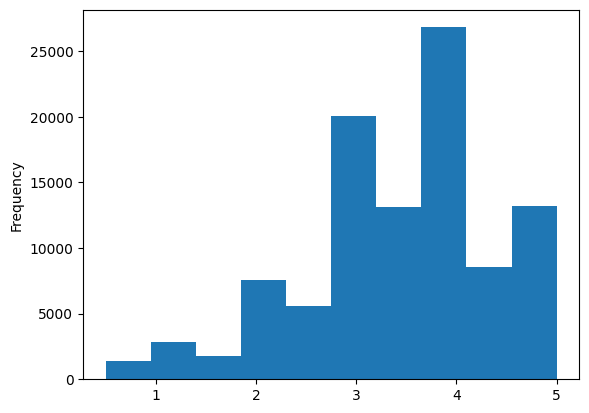

In [11]:
ratings.rating.plot.hist()
print("Unique Rating (0.5 as Bin)" , ratings.rating.unique())

In [12]:
# ratings.movieId.unique()
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22
100832,610,168248,5.0,2017-05-03 22:21:31
100833,610,168250,5.0,2017-05-08 19:50:47
100834,610,168252,5.0,2017-05-03 21:19:12


In [13]:
# Unique movie id is skipped, we consider normalizing the id to its index
np.sort(ratings.movieId.unique())

array([     1,      2,      3, ..., 193585, 193587, 193609])

In [14]:
# Most of them are unique
tags.tag.value_counts()

,count
tag,
In Netflix queue,131
atmospheric,36
thought-provoking,24
superhero,24
funny,23
...,...
small towns,1
In Your Eyes,1
Lloyd Dobbler,1


In [15]:
def get_normalize_x(x:List[int]):
  """
    Get the order index of any list item
  """
  return {v: i for i, v in enumerate(x)}

def reverse_dictionary(dct):
  """
  REverse key and value

  Our use case to inverse back a normalized index back
  """
  reverse_dct = {}
  for k, v in dct.items():
    reverse_dct[v] = k
  return reverse_dct

def train_test_split_by_last_items(df:pd.DataFrame,
                                   n_last:int = 3,
                                   user_col = "userId",
                                   timestamp_col = "timestamp"
                                   ):
  """
    Train & Test split based on the last item
    Where the validation set contains only the last n_last based on the timestamp
  """
  test_df = df.sort_values(timestamp_col).groupby(user_col).tail(n_last)
  test_idx = test_df.index
  train_idx = list(set(df.index) - set(test_df.index))

  # This is used for train set
  train_df = df.loc[train_idx]
  return train_df, test_df

# This is safe for every user to be sliced the last 5 rating, since they are at least rating for 20 movies
train_df, test_df = train_test_split_by_last_items(ratings.copy(), 5)

In [16]:
# Let's validate with bare eye, we can see that it does take the last 5 ratings
display(ratings.query("userId == 1").sort_values("timestamp",ascending=False)[:5])
display(test_df.query("userId == 1"))

display(ratings.query("userId == 23").sort_values("timestamp",ascending=False)[:5])
display(test_df.query("userId == 23"))

,userId,movieId,rating,timestamp
161,1,2492,4.0,2000-08-08 07:27:42
119,1,2012,4.0,2000-07-30 19:09:36
160,1,2478,4.0,2000-07-30 19:09:29
31,1,553,5.0,2000-07-30 19:09:13
95,1,1445,3.0,2000-07-30 19:08:32


,userId,movieId,rating,timestamp
95,1,1445,3.0,2000-07-30 19:08:32
31,1,553,5.0,2000-07-30 19:09:13
160,1,2478,4.0,2000-07-30 19:09:29
119,1,2012,4.0,2000-07-30 19:09:36
161,1,2492,4.0,2000-08-08 07:27:42


,userId,movieId,rating,timestamp
3853,23,2726,4.0,2005-02-18 05:05:48
3781,23,6,4.0,2005-02-02 11:04:27
3848,23,2194,3.0,2005-02-02 11:03:30
3806,23,1036,3.0,2005-02-02 11:03:23
3790,23,300,3.0,2005-02-02 11:03:07


,userId,movieId,rating,timestamp
3790,23,300,3.0,2005-02-02 11:03:07
3806,23,1036,3.0,2005-02-02 11:03:23
3848,23,2194,3.0,2005-02-02 11:03:30
3781,23,6,4.0,2005-02-02 11:04:27
3853,23,2726,4.0,2005-02-18 05:05:48


In [17]:
# Let's make an order index
normalized_movie_mapping = get_normalize_x( list(np.sort(ratings.movieId.unique())) )
normalized_user_mapping = get_normalize_x( list(np.sort(ratings.userId.unique())) )

# Again, we make a reverse dictionary to map back
unnormalized_movie_mapping = reverse_dictionary( normalized_movie_mapping )
unnormalized_user_mapping = reverse_dictionary( normalized_user_mapping )

In [18]:
# Create another ratings dataframe where extra columns are normalized user id
ratings_explicit = ratings.copy()
ratings_explicit["normalized_user_id"] = ratings_explicit["userId"].map(normalized_user_mapping)
ratings_explicit["normalized_movie_id"] = ratings_explicit["movieId"].map(normalized_movie_mapping)

"""
This is a raw user-item matrix which collect the matrix
"""
def get_raw_user_item_matrix(df=ratings_explicit):
  # Extract user IDs, movie IDs, and ratings
    user_ids = df['normalized_user_id'].values
    movie_ids = df['normalized_movie_id'].values
    ratings = df['rating'].values

    raw_user_item_matrix = csr_matrix((ratings, (user_ids, movie_ids)))
    return raw_user_item_matrix

# This is a raw_user_item_matrix
raw_user_item_matrix = get_raw_user_item_matrix()

# Test
print(raw_user_item_matrix[0,0])
print(raw_user_item_matrix[0,1])
print(raw_user_item_matrix[0,2])

# Some use case where we want the first
print(raw_user_item_matrix[0].max())

4.0
0.0
4.0
5.0


In [19]:
def get_top_movies_for_user(raw_user_item_matrix, user_index, top_n=3):
    # Get the row corresponding to the user_index
    user_ratings = raw_user_item_matrix[user_index]

    # Extract the non-zero indices and ratings
    nonzero_indices = user_ratings.indices
    nonzero_ratings = user_ratings.data

    # Get the indices of the top N ratings
    top_indices = np.argsort(nonzero_ratings)[-top_n:][::-1]

    # Get the top movie indices and their corresponding ratings
    top_movie_indices = nonzero_indices[top_indices]
    top_ratings = nonzero_ratings[top_indices]

    return top_movie_indices, top_ratings


user_index = 1  # Index of the user for whom we want the top-rated movies
top_n = 3  # Number of top-rated movies to retrieve

top_movies_id, top_ratings = get_top_movies_for_user(raw_user_item_matrix, user_index, top_n)

# Unnormalize them
top_movies_id = [unnormalized_movie_mapping.get(i) for i in top_movies_id]

# Let
ratings.query("userId == 2 & movieId in @top_movies_id")

,userId,movieId,rating,timestamp
250,2,89774,5.0,2015-10-24 19:33:09
254,2,106782,5.0,2015-10-24 19:29:26
260,2,131724,5.0,2015-10-24 19:27:31


In [20]:
# @title Util function
# @title This contains all model saved and loaded version

def save_model(model: torch.nn.Module, filepath: str):
    """
    Save the model's state dictionary to a file.

    Args:
        model (torch.nn.Module): The model to be saved.
        filepath (str): Path to the file where the model state dictionary will be saved.
    """
    torch.save(model.state_dict(), filepath)
    print(f'Model saved to "{filepath}".')


def load_model(model: torch.nn.Module, filepath: str, device: str = 'cpu'):
    """
    Load a model's state dictionary from a file.

    Args:
        model (torch.nn.Module): The model to which the state dictionary will be loaded.
        filepath (str): Path to the file from which the model state dictionary will be loaded.
        device (str, optional): Device to which the model should be loaded (default is 'cpu').
    """
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    print(f'Model loaded from "{filepath}".')

## Create a PyTorch Dataset
- Since we are using PyTorch as our framework, we need to create a PyTorch dataset to speed up and efficiently retrieve the data.







In [21]:
# @title Dataset

class MovieLensDataset(Dataset):
    """
    A PyTorch Dataset class for the MovieLens dataset.
    """
    def __init__(self,
                 df:pd.DataFrame,
                 normalized_user_mapping = normalized_user_mapping,
                 normalized_movie_mapping = normalized_movie_mapping,
                 ):
        """
        Load the MovieLens dataset and create a mapping from user and movie IDs to
        their normalized indices.
        """
        self.df = df

        # Extract unique user and movie IDs
        self.users = np.unique(self.df['userId'])
        self.movies = np.unique(self.df['movieId'])
        self.normalized_user_mapping = normalized_user_mapping
        self.normalized_movie_mapping = normalized_movie_mapping

        # Map to normalized index
        self.size = len(self.users), len(self.movies)
        self._process()

    def _process(self):
        # Convert to tensor
        self.user_tensor = torch.tensor(self.df['userId'].map(normalized_user_mapping).values, dtype=torch.int64)
        self.item_tensor = torch.tensor(self.df['movieId'].map(normalized_movie_mapping).values, dtype=torch.int64)
        self.target_tensor = torch.tensor(self.df['rating'].values, dtype=torch.float32)

    def __len__(self) -> int:
        """
        Return the number of data points in the dataset.
        """
        return len(self.df)

    def __getitem__(self, index: int) -> tuple[torch.LongTensor, torch.LongTensor, torch.FloatTensor]:
        """
        Retrieve a data point from the dataset.

        Args:
            index (int): The index of the data point to retrieve.

        Returns:
            tuple: A tuple of (user_id, movie_id, rating).
        """
        user_id = self.user_tensor[index]
        movie_id = self.item_tensor[index]
        rating = self.target_tensor[index]

        return user_id, movie_id, rating

In [22]:
train_dataset = MovieLensDataset(train_df)

# Compare dataset and actual
print(train_dataset[0])
display(train_df.iloc[0])

print(train_dataset[-1])
display(train_df.iloc[-1])

(tensor(0), tensor(0), tensor(4.))


,0
userId,1
movieId,1
rating,4.0
timestamp,2000-07-30 18:45:03


(tensor(609), tensor(9485), tensor(3.))


,100835
userId,610
movieId,170875
rating,3.0
timestamp,2017-05-03 21:20:15


## Create Architecture
- Our main architecture for the recommendation system is matrix factorization. We have two options for this:
  1. Plain Matrix Factorization (MF).
  2. MF with a clipping technique using the sigmoid function (to limit the output to be within 1-5).



In [23]:
# @title Construct the architecture

class MFNet(nn.Module):
    """
    A PyTorch embeddings for matrix factorization.

    Args:
        num_users (int): The number of users in the dataset.
        num_movies (int): The number of movies in the dataset.
        embedding_size (int): The size of the embedding vectors.
    """

    def __init__(self, num_users: int, num_items: int, embedding_size: int):
        """
        Create the user and movie embedding layers.
        """
        super(MFNet, self).__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.item_embeddings = nn.Embedding(num_items, embedding_size)

        # Since the standard of each movie
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

    def forward(self, user_idx: torch.Tensor, item_idx: torch.Tensor) -> torch.Tensor:
        """
        Compute the predicted rating for a given user and movie.

        Args:
            user_idx (torch.Tensor): The index of the user.
            movie_idx (torch.Tensor): The index of the movie.

        Returns:
            torch.Tensor: The predicted rating.
        """
        user_emb = self.user_embeddings(user_idx)  # type: torch.Tensor
        movie_emb = self.item_embeddings(item_idx)  # type: torch.Tensor

        user_bias = self.user_biases(user_idx)
        movie_bias = self.item_biases(item_idx)

        rating = torch.sum(user_emb * movie_emb, dim=1)
        rating = rating + user_bias.squeeze() + movie_bias.squeeze()

        return rating

    def __repr__(self):
        return f"MFNet({num_users=}, {num_items=}, {embedding_size=})"

# Create the MatrixFactorization model
num_users, num_movies = train_dataset.size
model = MFNet(num_users, num_movies, embedding_size = 16)

# Single Instance
output1 = model(torch.tensor([0]),torch.tensor([1]))
output2 = model(torch.tensor([0,1,2]),torch.tensor([1,2,3]))

print("Individual : ", output1)
print("Batch : ", output2)

Individual :  tensor([-1.8701], grad_fn=<AddBackward0>)
Batch :  tensor([-1.8701, -0.7302, -6.7457], grad_fn=<AddBackward0>)


In [24]:
class MFNetSigmoidRange(nn.Module):
    """
    MFNet but restrict the output range using sigmoud activation function
    """
    def __init__(self, num_users, num_items, embedding_size, output_range:Tuple[float,float]=(0.8,5.2)):
        """
        We recommend the min and max of output range to add with some residual
        since the steepest slope of the min and max is exactly zero, hence it is impossible to learn to predict the exact min and max
        """
        super().__init__()

        self.output_range = output_range
        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.item_embeddings = nn.Embedding(num_items, embedding_size)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

    def forward(self, user_idx: torch.Tensor, movie_idx: torch.Tensor) -> torch.Tensor:
        user_emb = self.user_embeddings(user_idx)  # type: torch.Tensor
        item_emb = self.item_embeddings(movie_idx)  # type: torch.Tensor

        user_bias = self.user_biases(user_idx)
        item_bias = self.item_biases(movie_idx)

        rating = torch.sum(user_emb * item_emb, dim=1)
        rating = rating + user_bias.squeeze() + item_bias.squeeze()

        # Post-process to fit with output constraint
        rating = torch.sigmoid(rating)
        rating = rating * (self.output_range[1] - self.output_range[0]) + self.output_range[0]
        return rating

    def __repr__(self):
        return f"MFNetSigmoidRange({num_users=}, {num_items=}, {embedding_size=})"

model = MFNetSigmoidRange(num_users, num_movies, embedding_size = 16)

# Single Instance
output1 = model(torch.tensor([0]),torch.tensor([1]))
output2 = model(torch.tensor([0,1,2]),torch.tensor([1,2,3]))

print("Individual : ", output1)
print("Batch : ", output2)

Individual :  tensor([1.4404], grad_fn=<AddBackward0>)
Batch :  tensor([1.4404, 1.7910, 0.8957], grad_fn=<AddBackward0>)


In [25]:
def get_mf_model(version="with_sigmoid_range"):
  """
    Every MFNet require the same argument <n_users, n_items, emb_size>
  """
  mf_model_map = {
      "default" : MFNet,
      "with_sigmoid_range" : MFNetSigmoidRange,
  }
  mf_model = mf_model_map.get(version,mf_model_map["default"])
  return mf_model

In [26]:
# Let's log the unique number of user and item before we dive to making of the model
ratings.userId.nunique(), ratings.movieId.nunique()

(610, 9724)

In [27]:
# @title 🏹 Predefining Metric for evaluation
# Ps. we did not use at this time

# Recall@k function
def recall_at_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

# Function to get top-k recommendations
def get_top_k_recommendations(model, user_id, k=10):
    all_movie_ids = get_all_movie_ids()
    user_ids = torch.tensor([user_id] * len(all_movie_ids)).to(DEVICE)
    all_movie_ids = torch.tensor(all_movie_ids).to(DEVICE)

    with torch.no_grad():
        predictions = model(user_ids, all_movie_ids)

    _, top_k_indices = torch.topk(predictions, k)
    top_k_movie_ids = all_movie_ids[top_k_indices]
    return top_k_movie_ids.cpu().numpy()

In [28]:
# @title Declare metrics recall_at_k as another

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy model function
class DummyModel:
    def __call__(self, user_ids, movie_ids):
        # Generate random predictions
        return torch.rand(len(movie_ids)).to(DEVICE)

# Dummy function to get all movie IDs
def get_all_movie_ids():
    return np.arange(1, 101)  # Let's assume we have 100 movies

# Test cases
def test_recall_at_k():
    actual = [1, 2, 3, 4, 5]
    predicted = [5, 4, 3, 2, 20, 6, 7, 8, 9, 10]
    k = 5
    recall = recall_at_k(actual, predicted, k)
    print(f'Test Recall@{k}: {recall:.4f}')  # Expected output: 0.8 (Since it does not recommend 1)

def test_get_top_k_recommendations():
    model = DummyModel()
    user_id = 1
    k = 10
    top_k_recommendations = get_top_k_recommendations(model, user_id, k)
    print(f'Top-{k} recommendations for user {user_id}: {top_k_recommendations}')
    # Expected output: array of 10 movie IDs (random)

# Run test cases
test_recall_at_k()
test_get_top_k_recommendations()

Test Recall@5: 0.8000
Top-10 recommendations for user 1: [51 60 90 35 31 46 30 32 67 56]


In [29]:
# model = MFNetSigmoidRange(num_users, num_movies, embedding_size = 16)

# user_id_list = [1,2,3]

# candidates = ratings.query("userId in @user_id_list")
# model = MFNetSigmoidRange(num_users, num_movies, embedding_size = 16)

# # Perform analytics function for every single row
# # Syntax like MAX() PARTITION BY (userId)
# max_ratings = candidates.groupby("userId")["rating"].transform("max")
# max_ratings

## ⚾ Defining how we recommend the user after we trained our model

- One widely used method is User Collaborative Learning.
  1. First, we identify the top k similar users. (```get_similar_users(..)```)
  2. We retrieve all movie candidates, which include all movies except those the user has already watched. (```get_movie_candidate_id(..)```)
  3. Since We consider a scenario where each movie is unique, resulting in all votes being 1. We then re-rank the movies using our model to compare the user with all movies and select the top k. (```recommend(..)```)

In [30]:
from functools import partial
from typing import Union, Callable, Literal

def get_similar_items(
    user_id:int,
    k:int,
    embeddings,
    normalized_item_mapping,
    unnormalized_item_mapping,
    is_input_normalized:bool=True,
    is_output_unnormalized=True,
    ):
  """
  Get the similar user based on the cosine similarity

  Args
  ----
  is_input_normalized (bool) : is the input_user is normalized or not
  is_input_normalized (bool) : is the user is normalized or not
  """
  normalized_user_id = normalized_item_mapping[user_id] if not is_input_normalized else user_id

  vector = embeddings[normalized_user_id]
  matrix = embeddings
  # Expand the vector to match the matrix's shape
  vector_expanded = vector.unsqueeze(0).expand_as(matrix)

  cosine_score = F.cosine_similarity(matrix, vector_expanded, dim=1)

  topk_values, topk_indices = torch.topk(cosine_score, k+1)

  # Pop the first index of both tensors by slicing
  topk_values_popped = topk_values[1:].tolist()
  topk_indices_popped = topk_indices[1:].tolist()

  if is_output_unnormalized:
    topk_indices_popped = [unnormalized_item_mapping[id] for id in topk_indices_popped]

  return topk_values_popped, topk_indices_popped

# Partialize the function
get_similar_users = partial(get_similar_items, normalized_item_mapping=normalized_user_mapping, unnormalized_item_mapping=unnormalized_user_mapping)
get_similar_movies = partial(get_similar_items, normalized_item_mapping=normalized_movie_mapping, unnormalized_item_mapping=unnormalized_movie_mapping)

def get_user_watched_movie_id(user_id:Union[int,List[int]])->List[int]:
  """
  Get the watched movies from user id
  """
  global rating
  watched_movies = ratings.query(f"userId == {user_id}") if isinstance(user_id,int) else ratings.query(f"userId in @user_id")
  watched_movies = list(watched_movies["movieId"].unique())
  return watched_movies

def get_movie_candidate_id(
    user_id_list:List[int],
    exclude_movie_id_list:List[int],
    k:int = 5
    )->List[int]:
  global ratings
  candidates = get_user_watched_movie_id(user_id_list)

  movie_candidate_id_list = set(candidates) - set(exclude_movie_id_list)
  return movie_candidate_id_list

def recommend_by_similar_score(
    user_id:int,
    movie_candidate_id_list:List[int],
    model:Callable,
    k:int = 5,
    is_input_normalized:bool=True,
    is_output_unnormalized:bool=True
    ):
  """
    Recommend the user based on the predicted rating score between the user and all movie's candidate
  """
  global ratings, normalized_user_mapping, unnormalized_user_mapping, normalized_movie_mapping, unnormalized_movie_mapping, device

  normalized_user_id = normalized_user_mapping[user_id] if is_input_normalized else user_id
  normalized_movie_id_list = [normalized_movie_mapping[movie_id] for movie_id in movie_candidate_id_list]

  normalized_user_id_tensor = torch.tensor([normalized_user_id],dtype=torch.long).to(DEVICE)
  normalized_movie_id_tensor = torch.tensor(normalized_movie_id_list,dtype=torch.long).to(DEVICE)

  # Inference the rating
  pred_ratings = model(normalized_user_id_tensor,normalized_movie_id_tensor)

    # Use torch.topk to get the top k values and their indices
  top_score, top_k = torch.topk(pred_ratings,k)
  top_movie = normalized_movie_id_tensor[top_k]

  # Convert the results to CPU if needed for easier readability
  top_score = list(top_score.cpu().detach().numpy())
  top_movie = list(top_movie.cpu().detach().numpy())

  # TODO : output normalize back
  top_movie = [unnormalized_movie_mapping[movie_id] for movie_id in top_movie]

  return top_score, top_movie

# Pre calculate for weighted_average_rating method
# Function to calculate similarity matrix (using Pearson correlation for this example)
def recommend(user_id,
              user_embeddings,
              model,
              k:int=5):
  """
  Finalize the function
  """
  # Exclude the watched movie from a list of recommended item
  excluded_movie_candidates = get_user_watched_movie_id(user_id) # Unnormalized movie id

  # Get the most similar user using user_embeddings
  top_score_list, top_user_id_list = get_similar_users(user_id,k,user_embeddings)

  # Get all movie candidates from the similar user
  movie_candidate_id_list = get_movie_candidate_id(top_user_id_list, excluded_movie_candidates) # Unnormalized movie id

  # Get Top movie with their score for recommending
  top_score, top_movie = recommend_by_similar_score(user_id, movie_candidate_id_list, model, k)

  return top_score, top_movie

- We proposed another way to ranking with these type of similarity, however, this is not great as we used the previous similarity

In [31]:
# Testing the recommendation system with the untrained model and user embedding
# 1. Config
user_id = 2
k = 3
model = MFNetSigmoidRange(num_users, num_movies, embedding_size = 16).to(DEVICE)
user_embeddings = model.user_embeddings.weight.data
# 2. Inference
top_score, top_movie = recommend(user_id,user_embeddings,model,k=3)
print("Top recommendations (movie_id, predicted_rating):")
for predicted_rating, movie_id in zip(top_score, top_movie):
    print(f"Movie {movie_id}: {predicted_rating:.2f}")

Top recommendations (movie_id, predicted_rating):
Movie 1066: 5.20
Movie 1518: 5.19
Movie 3649: 5.19


In [32]:
def calculate_manual_similarity(ratings_arr):
    mean_user_rating = ratings_arr.mean(axis=1)
    ratings_diff = ratings_arr - mean_user_rating[:, np.newaxis]
    sim = np.dot(ratings_diff, ratings_diff.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / (norms * norms.T))

# Create user-item rating matrix
ratings_arr = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0).values
# Calculate similarity matrix
manual_similarities = calculate_manual_similarity(ratings_arr)

def recommend_by_weighted_average_ratings(
    user_id: int,
    movie_candidate_id_list: List[int],
    k: int = 5,
    is_input_normalized: bool = True,
    is_output_unnormalized: bool = True,
):
    """
    Recommend the user based on the weighted average rating score between the user and all movie's candidates.
    """
    global ratings_arr, similarities, normalized_user_mapping, unnormalized_user_mapping, normalized_movie_mapping, unnormalized_movie_mapping, device

    normalized_user_id = normalized_user_mapping[user_id] if is_input_normalized else user_id
    normalized_movie_id_list = [normalized_movie_mapping[movie_id] for movie_id in movie_candidate_id_list]

    user_ratings = ratings_arr[normalized_user_id, :]

    def predict_rating(user_index, item_index):
        rated_items = user_ratings.nonzero()[0]
        mean_user_rating = user_ratings[rated_items].mean() if rated_items.size > 0 else 0

        numerator = 0.0
        denominator = 0.0

        for other_user_index in range(ratings_arr.shape[0]):
            if other_user_index != user_index and ratings_arr[other_user_index, item_index] != 0:
                other_user_ratings = ratings_arr[other_user_index, :]
                mean_other_user_rating = other_user_ratings[other_user_ratings.nonzero()].mean() if other_user_ratings.nonzero()[0].size > 0 else 0

                sim = similarities[user_index, other_user_index]
                numerator += (ratings_arr[other_user_index, item_index] - mean_other_user_rating) * sim
                denominator += abs(sim)

        return mean_user_rating if denominator == 0 else mean_user_rating + (numerator / denominator)

    # Get
    top_score = []
    top_movie = []

    for normalized_movie_id in normalized_movie_id_list:

        predicted_rating = predict_rating(user_index, normalized_movie_id)
        movie_index = unnormalized_movie_mapping[normalized_movie_id] if is_output_unnormalized else normalized_movie_id  # Assuming movieId starts from 1
        top_score.append(predicted_rating)
        top_movie.append(movie_index)

    # Combine a and b, sort by the values in a, and then separate them back into two lists
    sorted_pairs = sorted(zip(top_score, top_movie),reverse=True)

    # Unzip the sorted pairs into separate lists
    top_score, top_movie = zip(*sorted_pairs)
    top_score, top_movie = list(top_score)[:k], list(top_movie)[:k]

    return top_score, top_movie

'''
def recommend(user_id,
              user_embeddings,
              k:int=5,
              method:Literal["similar","weight_average_ratings"]=""):
  """
  Finalize the function
  """
  # Exclude the watched movie from a list of recommended item
  excluded_movie_candidates = get_user_watched_movie_id(user_id)

  # Get the most similar user using user_embeddings
  top_score_list, top_user_id_list = get_similar_users(user_id,k,user_embeddings)

  # Get all movie candidates from the similar user
  movie_candidate_id_list = get_movie_candidate_id(top_user_id_list, excluded_movie_candidates)

  # Get Top movie with their score for recommending
  top_score, top_movie = recommend_by_weighted_average_ratings(user_id, movie_candidate_id_list, k)

  return top_score, top_movie
'''

'\ndef recommend(user_id,\n              user_embeddings,\n              k:int=5,\n              method:Literal["similar","weight_average_ratings"]=""):\n  """\n  Finalize the function\n  """\n  # Exclude the watched movie from a list of recommended item\n  excluded_movie_candidates = get_user_watched_movie_id(user_id)\n\n  # Get the most similar user using user_embeddings\n  top_score_list, top_user_id_list = get_similar_users(user_id,k,user_embeddings)\n\n  # Get all movie candidates from the similar user\n  movie_candidate_id_list = get_movie_candidate_id(top_user_id_list, excluded_movie_candidates)\n\n  # Get Top movie with their score for recommending\n  top_score, top_movie = recommend_by_weighted_average_ratings(user_id, movie_candidate_id_list, k)\n\n  return top_score, top_movie\n'

## Start Training
- We try a different set of hyperparameter, we select the best model with validation MSE

In [ ]:
"""
This script aims to perform grid search to find the best initial hyperparemters
"""

# Hyperparameter
architectures = [get_mf_model("default"), get_mf_model("with_sigmoid_range")]
embedding_sizes = [100, 200, 300]
learning_rates = [1e-2, 5e-2, 7e-2]
l2_weight_decays = [1e-2, 1e-3, 1e-4]

# Fixed hyperparameter & Data
n_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 512

# Early stopping parameters
patience = 10
min_delta = 1e-5

# Generate all combinations
hyperparameter_combinations = list(itertools.product(architectures, embedding_sizes, learning_rates,l2_weight_decays))

# Start setup based on hyperparameter
train_dataset = MovieLensDataset(train_df)
val_dataset = MovieLensDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_users, num_items = ratings.userId.nunique(), ratings.movieId.nunique()

candidate_scores = {}
min_global_val_loss = np.inf

# Create the MatrixFactorization model
for architecture, embedding_size, learning_rate, l2_weight_decay in hyperparameter_combinations:
  model = architecture(num_users, num_items, embedding_size).to(device)

  hyperparameter_settings = f"{model=}, {embedding_size=}, {learning_rate=} {l2_weight_decay=}"

  print(f"Setting {hyperparameter_settings}")

  # Loss and optimizer
  criterion = nn.MSELoss().to(device)
  optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_weight_decay)
  min_val_loss = np.inf
  epochs_no_improve = 0

  # Training loop
  for epoch in range(n_epochs):
      print(f'Epoch {epoch + 1}')
      running_loss = 0.0

      # Train Loop
      model.train()
      train_loop = tqdm(enumerate(train_loader), total=len(train_loader))
      for i, (users_id, movies_id, targets) in train_loop:
          users_id = users_id.squeeze().to(DEVICE)
          movies_id = movies_id.squeeze().to(DEVICE)
          targets = targets.squeeze().to(DEVICE)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(users_id, movies_id)

          # Compute the loss
          loss = criterion(outputs, targets)

          # Backpropagation and optimization
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          train_loop.set_postfix(loss=running_loss / (i + 1))

      running_loss = running_loss / len(train_loader)
      print(f'Train Loss: {running_loss}')

      # Validation Loop
      model.eval()
      val_loss = 0.0
      k = 10
      recall_k_sum = 0.0
      with torch.no_grad():
          for users_id, movies_id, targets in val_loader:
              users_id = users_id.squeeze().to(DEVICE)
              movies_id = movies_id.squeeze().to(DEVICE)
              targets = targets.squeeze().to(DEVICE)

              # Forward pass
              outputs = model(users_id, movies_id)

              # Compute the loss
              loss = criterion(outputs, targets)

              val_loss += loss.item()

      val_loss = val_loss / len(val_loader)
      print(f'Validation Loss: {val_loss}')

      # Save the model if validation loss decreases

      # Early stopping check
      if val_loss < min_val_loss - min_delta:
          min_val_loss = val_loss
          epochs_no_improve = 0

      else:
          epochs_no_improve += 1
          if epochs_no_improve >= patience:
              print(f'Early stopping after {epoch + 1} epochs')
              break

      if val_loss < min_global_val_loss:
          save_model(model, 'best_mfnet_param.pth')
          min_global_val_loss = val_loss

  print('Finished Training')
  candidate_scores[hyperparameter_settings] = min_val_loss
  break

- If you avoid retraining, to get the best parameter from our training, You can download from our repository below :

In [41]:
!curl -o best_mfnet_param.pth https://raw.githubusercontent.com/wallik3/movie-len-recommendation/main/artifact/model/best_mfnet_param.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     2  100     2    0     0     23      0 --:--:-- --:--:-- --:--:--    23


## Let's test the recommendation system

In [36]:
num_users, num_items = ratings.userId.nunique(), ratings.movieId.nunique()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model
architecture = get_mf_model("with_sigmoid_range")
model = architecture(num_users, num_items, embedding_size=100).to(device)
model.load_state_dict(torch.load('best_mfnet_param.pth',weights_only=True))
user_embeddings = model.user_embeddings.weight.data

- Before testing our recommendation system, we need to check the top most viewed movies

In [42]:
# Let's get the top most count 30 movies
id_to_movie_title = movies.set_index("movieId").to_dict()["title"]

# Get the top movies based on count
top_movies = ratings.groupby("movieId").agg(movie_count=("movieId","count")).reset_index().sort_values("movie_count",ascending=False).head(30)
top_movies["movie_name"] = top_movies["movieId"].map(id_to_movie_title)
top_movies

,movieId,movie_count,movie_name
314,356,329,Forrest Gump (1994)
277,318,317,"Shawshank Redemption, The (1994)"
257,296,307,Pulp Fiction (1994)
510,593,279,"Silence of the Lambs, The (1991)"
1938,2571,278,"Matrix, The (1999)"
224,260,251,Star Wars: Episode IV - A New Hope (1977)
418,480,238,Jurassic Park (1993)
97,110,237,Braveheart (1995)
507,589,224,Terminator 2: Judgment Day (1991)
461,527,220,Schindler's List (1993)


In [43]:
# We can get the similar movie via the same user function
"""
If result of similar movies does not make sense,
it oftens indicate that the number of movies is not high enough to be trained
"""

selected_movie_id = 7153 # [318, 7153,116797,356,318]
movie = movies.query("movieId == @selected_movie_id")
movie_title, movie_genres = movie.title.values[0], movie.genres.values[0]
print(f"Query Movie : {movie_title} with genre {movie_genres}")

movie_scores, similar_movies_idx = get_similar_movies(
    selected_movie_id,
    k=10,
    embeddings=model.item_embeddings.weight.data,
    is_input_normalized=False,
    is_output_unnormalized=True
)

print("Ranking : ")
for i, (similar_movie_idx, movie_score) in enumerate(zip(similar_movies_idx,movie_scores)):
  movie = movies.query("movieId == @similar_movie_idx")
  movie_title, movie_genres = movie.title.values[0], movie.genres.values[0]
  print(f"{i}. {[similar_movie_idx]} {movie_title} with genre {movie_genres} - Score : {movie_score}")

Query Movie : Lord of the Rings: The Return of the King, The (2003) with genre Action|Adventure|Drama|Fantasy
Ranking : 
0. [4993] Lord of the Rings: The Fellowship of the Ring, The (2001) with genre Adventure|Fantasy - Score : 0.6373259425163269
1. [5952] Lord of the Rings: The Two Towers, The (2002) with genre Adventure|Fantasy - Score : 0.6142592430114746
2. [143458] The Great Hypnotist (2014) with genre Drama|Mystery|Thriller - Score : 0.39996057748794556
3. [98809] Hobbit: An Unexpected Journey, The (2012) with genre Adventure|Fantasy|IMAX - Score : 0.38641566038131714
4. [7218] Ox-Bow Incident, The (1943) with genre Drama|Western - Score : 0.37873727083206177
5. [4572] Black Rain (1989) with genre Action|Crime|Drama - Score : 0.37066560983657837
6. [104141] Batman: Mystery of the Batwoman (2003) with genre Action|Animation|Children|Crime - Score : 0.3642524480819702
7. [6380] Capturing the Friedmans (2003) with genre Documentary - Score : 0.3562476336956024
8. [3186] Girl, Interr

- Use case: We recommend movies to users who love crime and thriller genres, and our model can suggest similar genres.

In [40]:
ratings.query("movieId == 4993")

,userId,movieId,rating,timestamp
950,7,4993,4.5,2005-01-25 07:03:09
1097,9,4993,5.0,2003-02-07 22:30:51
1140,10,4993,4.0,2016-02-13 09:39:45
1498,15,4993,3.5,2017-11-13 11:15:54
1649,16,4993,3.5,2013-08-26 00:34:49
...,...,...,...,...
95901,601,4993,5.0,2015-09-07 15:25:20
97255,605,4993,5.0,2010-06-22 03:00:27
98052,606,4993,4.5,2007-02-13 14:14:07
99303,608,4993,4.5,2005-05-29 23:02:19


In [44]:
user_to_recommend = 9 #[5,150,250,500]
watched_movie_id = list(ratings.query(f"userId == {user_to_recommend}").movieId.unique())

watched_movie = (movies.query("movieId in @watched_movie_id"))
print("Watched movie : ")
display(watched_movie)

watched_movie_title = list(watched_movie.title.unique())

# Let's try recommending the user
top_score, top_movie = recommend(user_to_recommend,user_embeddings,model,k=20)
watched_movie = list(movies.query("movieId in @top_movie").title.unique())

print("Recommended Movie (From best) : ")
display(movies.query("movieId in @top_movie"))

Watched movie : 


,movieId,title,genres
37,41,Richard III (1995),Drama|War
158,187,Party Girl (1995),Comedy
190,223,Clerks (1994),Comedy
329,371,"Paper, The (1994)",Comedy|Drama
532,627,"Last Supper, The (1995)",Drama|Thriller
704,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
705,923,Citizen Kane (1941),Drama|Mystery
794,1037,"Lawnmower Man, The (1992)",Action|Horror|Sci-Fi|Thriller
834,1095,Glengarry Glen Ross (1992),Drama
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure


Recommended Movie (From best) : 


,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
463,529,Searching for Bobby Fischer (1993),Drama
474,541,Blade Runner (1982),Action|Sci-Fi|Thriller
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
711,930,Notorious (1946),Film-Noir|Romance|Thriller
820,1080,Monty Python's Life of Brian (1979),Comedy
856,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
907,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller


## Future Direction
- DeepNeuralMFNet is another deeper of making model, we will implement this architecture, and hopefully, can archieve a better recommendation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class DeepMFNet(nn.Module):
    """
    MFNet but restrict the output range using sigmoud activation function
    """
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_size,
                 hidden_layers: List[int],
                 output_range:Tuple[float,float]=(0.8,5.2)):
        """
        We recommend the min and max of output range to add with some residual
        since the steepest slope of the min and max is exactly zero, hence it is impossible to learn to predict the exact min and max
        """
        super().__init__()

        self.output_range = output_range
        self.user_embeddings = nn.Embedding(num_users, embedding_size)
        self.item_embeddings = nn.Embedding(num_items, embedding_size)

        # Define the network layers
        layers = []
        input_size = embedding_size * 2
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.SELU())
            input_size = hidden_size
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(input_size, 1)

    def forward(self, user_idx: torch.Tensor, item_idx: torch.Tensor) -> torch.Tensor:
        user_embeds = self.user_embeddings(user_idx)
        item_embeds = self.item_embeddings(item_idx)

        # Concatenate user and item embeddings
        x = torch.cat([user_embeds, item_embeds], dim=-1)

        # Pass through hidden layers
        x = self.hidden_layers(x)

        # Compute the raw output
        x = self.output(x)

        # Scale the output to the desired range
        min_val, max_val = self.output_range
        x = torch.sigmoid(x) * (max_val - min_val) + min_val
        return x

model = DeepMFNet(num_users, num_movies, embedding_size = 16, hidden_layers=[128,64,32])

# Single Instance
output1 = model(torch.tensor([0]),torch.tensor([1]))
output2 = model(torch.tensor([0,1,2]),torch.tensor([1,2,3]))

print("Individual : ", output1)
print("Batch : ", output2)

Individual :  tensor([[3.1933]], grad_fn=<AddBackward0>)
Batch :  tensor([[3.1933],
        [3.0021],
        [2.9401]], grad_fn=<AddBackward0>)
